# 2D thermal problem resolved by Finite Elements Method

In [1]:
from typing import Callable, List, Optional, Tuple, Dict
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.tri as tri

## A little bit theory

### **Physical Formulation**
The steady-state heat conduction equation in two dimensions describes the distribution of temperature $ T(x, y) $ in a domain $ \Omega $. The governing equation, assuming no time dependence, is given by:

$$
- \nabla \cdot (k \nabla T) = Q \quad \text{in } \Omega.
$$

where:
- $ k $ is the thermal conductivity (assumed isotropic),
- $ Q $ is the internal heat generation per unit volume,
- $ \nabla \cdot (k \nabla T) $ represents the heat diffusion term.

#### **Boundary Conditions**
- **Dirichlet boundary condition**: Prescribed temperature on a part of the boundary $ \Gamma_D $:
  $$ T = T_D \quad \text{on } \Gamma_D. $$
- **Neumann boundary condition**: Prescribed heat flux on a part of the boundary $ \Gamma_N $:
  $$ -k \frac{\partial T}{\partial n} = q_N \quad \text{on } \Gamma_N. $$

### **Weak Form Formulation**
Multiplying the heat equation by a test function $ v \in H^1(\Omega) $ and integrating over $ \Omega $:

$$
\int_{\Omega} -\nabla \cdot (k \nabla T) v \, d\Omega = \int_{\Omega} Q v \, d\Omega.
$$

Applying the divergence theorem to the diffusion term:

$$
\int_{\Omega} k \nabla T \cdot \nabla v \, d\Omega - \int_{\Gamma_N} q_N v \, d\Gamma = \int_{\Omega} Q v \, d\Omega.
$$

This is the weak form of the steady-state heat equation.

### **Spatial Discretization**
The domain $ \Omega $ is discretized into finite elements (e.g., triangular or quadrilateral elements). We approximate $ T(x, y) $ using shape functions:

$$
T_h(x, y) = \sum_{i=1}^{N} N_i(x, y) T_i,
$$

where:
- $ N_i(x, y) $ are the shape functions,
- $ T_i $ are the nodal temperatures,
- $ N $ is the number of nodes.

The test function $ v $ is chosen as $ v = N_j $, leading to the discrete system:

$$
K T = F,
$$

where:
- **Stiffness matrix**: $ K_{ij} = \int_{\Omega} k \nabla N_i \cdot \nabla N_j \, d\Omega $, 
- **Load vector**: $ F_i = \int_{\Omega} Q N_i \, d\Omega + \int_{\Gamma_N} q_N N_i \, d\Gamma $.

### **Shape Functions**
For a 2D triangular element with nodes $ (x_1, y_1), (x_2, y_2), (x_3, y_3) $, the linear shape functions are:

$$
N_1 = \frac{1}{2A} (a_1 + b_1 x + c_1 y), \quad N_2 = \frac{1}{2A} (a_2 + b_2 x + c_2 y), \quad N_3 = \frac{1}{2A} (a_3 + b_3 x + c_3 y),
$$

where $ A $ is the element area, and the coefficients are computed from the nodal coordinates.

## Problem geometry

In [2]:
class Geometry:
    """
    Class representing a discretized geometry for finite element meshing.
    """
    def __init__(
            self,
            nx_steps: int,
            ny_steps: int,
            shape_func: Callable[[float, float], bool]) -> None:
        """
        Initializes the geometry.

        :param nx_steps: Number of divisions in x.
        :param ny_steps: Number of divisions in y.
        :param shape_func: Function defining the shape to be meshed (returns True if a point belongs to the shape).
        """
        self.nx_steps = nx_steps
        self.ny_steps = ny_steps
        self.shape_func = shape_func
        self.nodes: List[Tuple[float, float]] = []  # List of mesh nodes
        self.elements: List[List[int]] = []  # List of elements (triangles or edges)
        self.build()

    def get_node_index_from_coordinates(self, x: float, y: float) -> int:
        """
        Returns the index of the node corresponding to the coordinates (x, y), or adds it if it does not exist.

        :param x: x-coordinate.
        :param y: y-coordinate.
        :return: Node index.
        """
        node_indexes = [i for i, t in enumerate(self.nodes) if t == (x, y)]
        if node_indexes:
            return node_indexes[0]
        self.nodes.append((x, y))
        return len(self.nodes) - 1
    
    def mesh_edges(self, coordinates: List[Tuple[float, float]]) -> None:
        """
        Creates an edge between two nodes given their coordinates.

        :param coordinates: List of two coordinates defining an edge.
        """
        nodes = [self.get_node_index_from_coordinates(*c) for c in coordinates]
        self.elements.append([nodes[0], nodes[1]])

    def mesh_surface(self, coordinates: List[Tuple[float, float]]) -> None:
        """
        Discretizes a rectangular surface into 4 triangles.

        :param coordinates: List of 4 rectangle corner points in counterclockwise order.
        """
        nodes = [self.get_node_index_from_coordinates(*c) for c in coordinates]
        
        # Add the center of the quadrilateral
        nodes.append(self.get_node_index_from_coordinates(
            (coordinates[0][0] + coordinates[2][0]) * .5,
            (coordinates[0][1] + coordinates[2][1]) * .5
        ))
        
        # Define triangles
        self.elements.append([nodes[0], nodes[1], nodes[4]])
        self.elements.append([nodes[1], nodes[2], nodes[4]])
        self.elements.append([nodes[2], nodes[3], nodes[4]])
        self.elements.append([nodes[3], nodes[0], nodes[4]])

    def build(self) -> None:
        """
        Builds the mesh based on the number of divisions and the shape function.
        """
        for i in range(self.nx_steps):
            for j in range(self.ny_steps):
                m = 1. / self.nx_steps
                n = 1. / self.ny_steps
                
                # Check if the point belongs to the given shape
                if self.shape_func(i * m, j * n):
                    self.mesh_surface([
                        (i * m, j * n),
                        ((i+1) * m, j * n),
                        ((i+1) * m, (j+1) * n),
                        (i * m, (j+1) * n)
                    ])
    
    def plot_mesh(self, figsize: Tuple[int, int] = (8, 8)) -> None:
        """
        Displays the generated mesh.

        :param figsize: Figure size in inches.
        """
        x, y = tuple(map(list, zip(*self.nodes)))
        edges = [elem for elem in self.elements if len(elem) == 2]
        triangles = [elem for elem in self.elements if len(elem) == 3]
        
        triang = tri.Triangulation(x=x, y=y, triangles=triangles)
        
        _, ax = plt.subplots(figsize=figsize)
        ax.triplot(triang, 'b-', lw=0.5)
        
        # Draw edges
        for node_indexes in edges:
            u, v = tuple(map(list, zip(*[self.nodes[i] for i in node_indexes])))
            ax.plot(u, v, 'g-', lw=2)
        
        ax.scatter(x, y, color='red', s=5)
        ax.set_title("Geometry mesh")
        plt.show()
    
    def plot_values(self, values: List[float], figsize: Tuple[int, int] = (8, 5)) -> None:
        """
        Displays an interpolation of values over the mesh.

        :param values: List of nodal values.
        :param figsize: Figure size in inches.
        """
        x, y = tuple(map(list, zip(*self.nodes)))
        triangles = [elem for elem in self.elements if len(elem) == 3]
        triang = tri.Triangulation(x=x, y=y, triangles=triangles)
        
        _, ax = plt.subplots(figsize=figsize)
        plt.tricontourf(triang, values, cmap="jet", levels=800)
        plt.colorbar(ax=ax)
        ax.triplot(triang, 'k-', lw=0.2)
        ax.set_title("Temperature")
        plt.show()


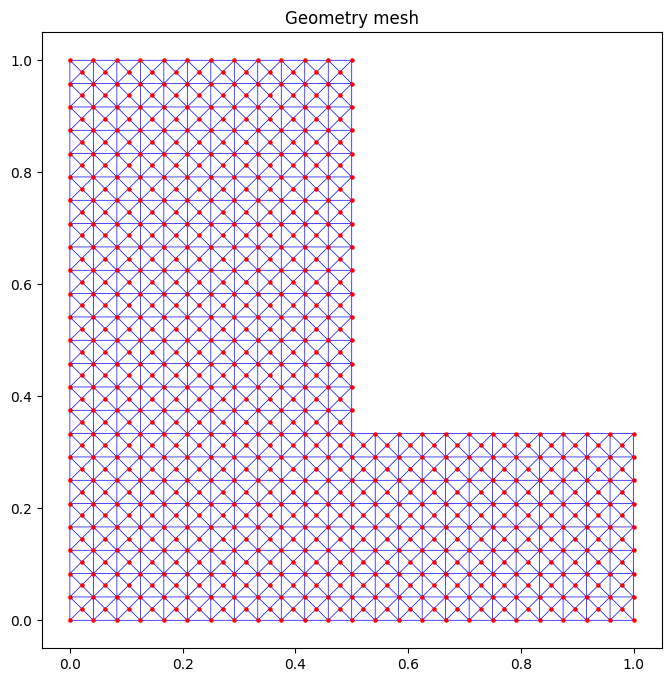

In [11]:
geom = Geometry(24, 24, lambda x, y: x < .5 or y < .3)
geom.plot_mesh()

## Finite element computation

In [4]:
class FEMThermal2DSolver:
    def __init__(self, 
                 nodes: List[Tuple[float, float]], 
                 elements: List[Tuple[int, int, int]], 
                 k: float = 1.0, 
                 Q: float = 0.0,
                 boundary_conditions: Optional[Dict[int, float]] = None):
        """
        Constructor for the FEM class for a 2D thermal problem.

        :param nodes: List of node coordinates (each node is a tuple (x, y))
        :param elements: List of elements, each element is a tuple of three node indices forming a triangle
        :param k: Thermal conductivity (default is 1.0)
        :param Q: Uniform heat source term (default is 0.0, meaning no internal heat generation)
        :param boundary_conditions: Dictionary of boundary conditions {node: temperature} (default is None)
        """
        self.nodes = np.array(nodes)
        self.elements = elements
        self.num_nodes = len(nodes)
        self.num_elements = len(elements)
        self.k = k
        self.Q = Q
        self.boundary_conditions = boundary_conditions if boundary_conditions is not None else {}
        
        # Initialize the global stiffness matrix and the global force vector
        self.K = np.zeros((self.num_nodes, self.num_nodes))  # Global stiffness matrix
        self.f = np.full(self.num_nodes, Q)  # Global force vector initialized with uniform heat source term

    def local_stiffness(self, element: Tuple[int, int, int]) -> np.ndarray:
        """
        Compute the local stiffness matrix for a triangular element.
        
        :param element: Indices of the nodes for the triangular element
        :return: Local stiffness matrix
        """
        coords = np.array([self.nodes[element[0]], self.nodes[element[1]], self.nodes[element[2]]])
        
        # Thermal conductivity matrix (assuming uniform conductivity k)
        C = np.array([[self.k, 0], [0, self.k]])  # For an isotropic material, we have a diagonal matrix
        
        # Compute the area of the triangle
        A = 0.5 * np.linalg.det(np.array([[1, coords[0, 0], coords[0, 1]],
                                          [1, coords[1, 0], coords[1, 1]],
                                          [1, coords[2, 0], coords[2, 1]]]))  # Area of the triangle
        
        # Compute the derivatives of the shape functions
        dN_dX = np.array([
            [coords[1, 1] - coords[2, 1], coords[2, 1] - coords[0, 1], coords[0, 1] - coords[1, 1]],
            [coords[2, 0] - coords[1, 0], coords[0, 0] - coords[2, 0], coords[1, 0] - coords[0, 0]]
        ]) / (2 * A)  # Derivatives of shape functions (dN/dx and dN/dy)

        # Compute local stiffness matrix
        K_local = A * (dN_dX.T @ C @ dN_dX)  # Standard FEM formulation for thermal conduction
        
        return K_local

    def assemble(self) -> None:
        """
        Assemble the global stiffness matrix by looping over all elements.
        """
        for elem in self.elements:
            K_local = self.local_stiffness(elem)
            
            # Assembly into the global stiffness matrix
            for i in range(3):  # Three nodes per triangle
                for j in range(3):
                    self.K[elem[i], elem[j]] += K_local[i, j]

    def apply_boundary_conditions(self) -> None:
        """
        Modify the system to enforce Dirichlet boundary conditions.
        """
        for node, temp in self.boundary_conditions.items():
            self.K[node, :] = 0  # Nullify the row corresponding to the node
            self.K[node, node] = 1  # Set the diagonal to 1
            self.f[node] = temp  # Set the temperature for this node

    def solve(self) -> np.ndarray:
        """
        Solve the system for the temperatures at the nodes.
        
        :return: Solution of the temperatures at the nodes
        """
        self.assemble()
        self.apply_boundary_conditions()
        
        # Solve the system
        temperature = np.linalg.solve(self.K, self.f)
        return temperature


In [12]:
boundary_conditions = {}

for i, (x, y) in enumerate(geom.nodes):
    
    # Hot source
    if y == 1:
        boundary_conditions[i] = 1

    # Cold source
    if x == 1:
        boundary_conditions[i] = 0

solver = FEMThermal2DSolver(
    nodes=geom.nodes,
    elements=list([(nodes[0], nodes[1], nodes[2]) for nodes in geom.elements if len(nodes) == 3]),
    k=1.,
    Q=.0,
    boundary_conditions=boundary_conditions)

temperatures = solver.solve()

## Result

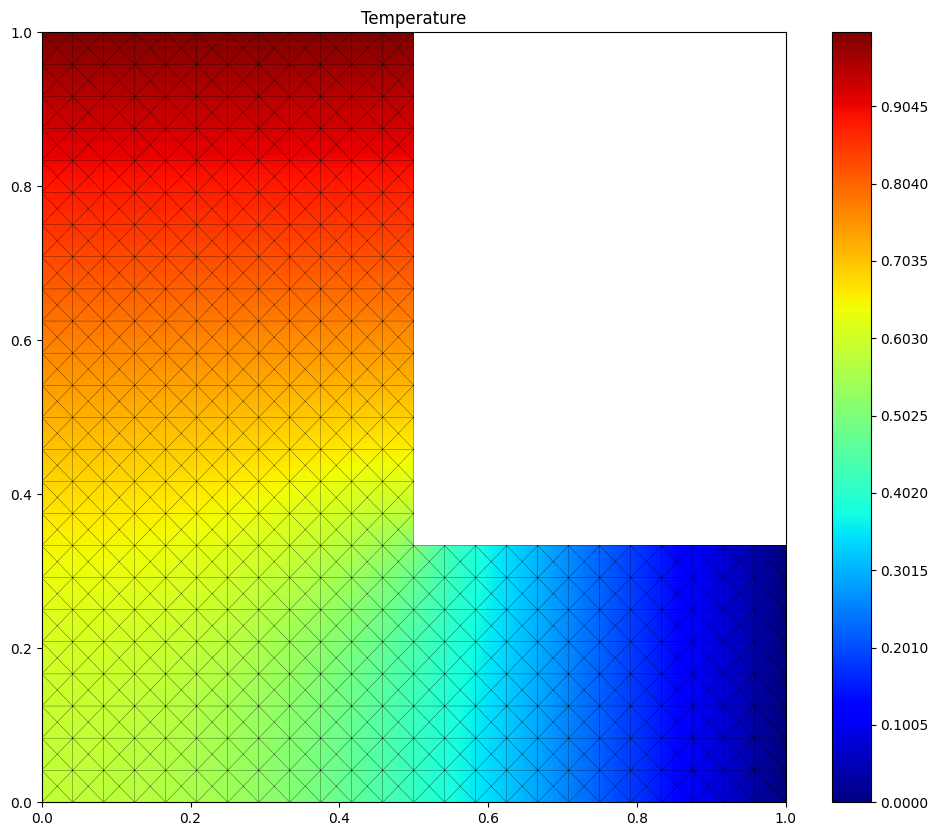

In [13]:
geom.plot_values(values=temperatures.tolist(), figsize=(12, 10))